In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%run imports.py

In [4]:
task = mnist.MNIST()
task.load_all_data(device)

/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# import tempfile
# tb_log_dir = tempfile.mkdtemp()
user = os.getlogin()
tb_log_dir = f'/tmp/tensorboard/{user}'

In [5]:
if os.path.exists(tb_log_dir):
    shutil.rmtree(tb_log_dir)

In [6]:
logger = tb.SummaryWriter(tb_log_dir, flush_secs=5)

In [6]:
import xarray as xr

In [14]:
n_pop = 100
n_gens = 10
n_seeds = 3
device = 'cuda:0'
net = models_pheno.BigConvNet().to(device)
triu_mask = torch.triu(torch.ones([n_pop]*2), diagonal=1).to(bool)

def run_evolution():
    pop = [torch.randn(util.count_params(net)).to(device)/6. for _ in range(n_pop)]
    fitdata = []
    loop = tqdm(range(n_gens), leave=False)
    for i in loop:
        a = torch.stack(pop)
        cossim = torch.cosine_similarity(a[None], a[:, None], dim=-1)[triu_mask].cpu().numpy()
        l2 = (a[None]-a[:, None]).norm(dim=-1).mean()
        l2sq = (a[None]-a[:, None]).norm(dim=-1).pow(2.).mean()

        fitdata.append(task.calc_pop_fitness(pop, lambda x: util.vec2model(x, net), 
                                             n_samples=1000, device=device))

        idx_selected = np.argsort(fitdata[-1].sel(metric='fitness'))[::-1][:30].data
        pop_selected = [pop[i] for i in idx_selected]
        npop = []
        for _ in range(n_pop):
            a, b = np.random.choice(len(pop_selected), size=(2), replace=False)
            c = util.uniform_crossover(pop_selected[a], pop_selected[b], p=0.5)
            c = util.additive_noise(c, eps=1e-2)
            npop.append(c.detach())
        pop = npop


        loop.set_postfix({'loss': fitdata[-1].sel(metric='loss').min().item()})
    fitdata = xr.concat(fitdata, dim='gen')
    return fitdata
    

fitdata = []
for seed in tqdm(range(n_seeds)):
    a = run_evolution()
    fitdata.append(a)
fitdata = xr.concat(fitdata, dim='seed')



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
a = []
for i in range(15):
    a.append(torch.load(f'data/runs/{i}.ans'))
a = xr.concat(a, dim='seed')
torch.save(f'data/runs/uniform_crossover.ans')

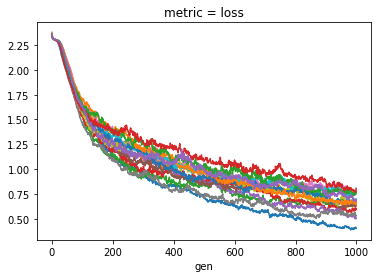

In [51]:
for seed in range(15):
    a.mean(dim='pop').sel(metric='loss', seed=seed).plot()

In [18]:
from collections import namedtuple

In [14]:
n_pop = 100
n_gens = 10
n_seeds = 3
device = 'cuda:0'
net = models_pheno.BigConvNet().to(device)
conet = models_breed.ConvRSBProbBreeder().to(device)
Genotype = namedtuple('Genotype', ['w', 'bw'])
triu_mask = torch.triu(torch.ones([n_pop]*2), diagonal=1).to(bool)

def run_evolution():
    pop = [torch.randn(util.count_params(net)).to(device)/6. for _ in range(n_pop)]
    fitdata = []
    loop = tqdm(range(n_gens), leave=False)
    for i in loop:
        a = torch.stack(pop)
        cossim = torch.cosine_similarity(a[None], a[:, None], dim=-1)[triu_mask].cpu().numpy()
        l2 = (a[None]-a[:, None]).norm(dim=-1).mean()
        l2sq = (a[None]-a[:, None]).norm(dim=-1).pow(2.).mean()

        fitdata.append(task.calc_pop_fitness(pop, lambda x: util.vec2model(x, net), 
                                             n_samples=1000, device=device))

        idx_selected = np.argsort(fitdata[-1].sel(metric='fitness'))[::-1][:30].data
        pop_selected = [pop[i] for i in idx_selected]
        npop = []
        for _ in range(n_pop):
            a, b = np.random.choice(len(pop_selected), size=(2), replace=False)
            c = util.uniform_crossover(pop_selected[a], pop_selected[b], p=0.5)
            c = util.additive_noise(c, eps=1e-2)
            npop.append(c.detach())
        pop = npop


        loop.set_postfix({'loss': fitdata[-1].sel(metric='loss').min().item()})
    fitdata = xr.concat(fitdata, dim='gen')
    return fitdata
    

fitdata = []
for seed in tqdm(range(n_seeds)):
    a = run_evolution()
    fitdata.append(a)
fitdata = xr.concat(fitdata, dim='seed')



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [283]:
util.count_params(net)*101*4/1e9

0.00086456

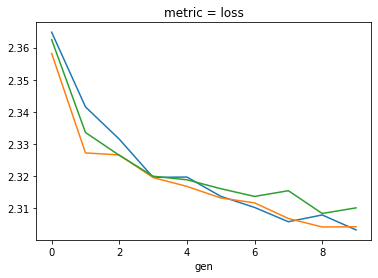

In [277]:
for seed in range(3):
    fitdata.sel(seed=seed, metric='loss').mean(dim='pop').plot()

In [28]:
import xarray as xr

In [96]:
a = xr.DataArray(np.random.randn(100, 3), dims=('pop', 'metric'), coords={'metric': ['loss', 'fitness', 'accuracy']})
b = xr.DataArray(np.random.randn(100, 3), dims=('pop', 'metric'), coords={'metric': ['loss', 'fitness', 'accuracy']})

In [132]:
class Neuroevolution(ga.SimpleGA):
    def __init__(self):
        super().__init__()
        
        self.calc_npop = partial(ga.calc_npop_tournament, 
                                 k_elite=3, k_tournament=5, do_crossover=True,
                                 calc_clone_fn=self.calc_clone,
                                 calc_mutate_fn=self.calc_mutate,
                                 calc_crossover_fn=self.calc_crossover, )
        
        self.pop_evol = {}
        
    def ask(self):
        if self.gen_idx>1:
            if self.gen_idx<10 or self.gen_idx%30==0:
                self.pop_evol[self.gen_idx] = self.pop
        return super().ask()
    
    def calc_ipop(self):
        return [genotype.Genotype.generate_random(pheno_class=pheno_class, pheno=pheno,
                                                  breeder_class=breeder_class, breeder=breeder,
                                                  mutator_class=mutator_class, mutator=mutator, device=device) 
                for _ in range(50)]
    def calc_clone(self, xs):
        return xs
    def calc_mutate(self, xs):
        return [a.mutate() for a in xs]
    def calc_crossover(self, xs1, xs2):
        return [a.crossover(b) for a,b in zip(xs1, xs2)]


In [147]:
seed = 400
n_gens = 100

torch.manual_seed(seed); np.random.seed(seed)
pheno_class = models_pheno.SmallNet
pheno = pheno_class().to(device)
breeder_class = models_breed.UniformBreeder
# breeder_class = partial(models_breed.ConvRSBProbBreeder, breeder_init_zeros=True)
breeder = breeder_class().to(device)
mutator_class = partial(models_mutate.AGMutator, eps=1e-2, adaptive_eps=False)
# mutator_class = partial(models_mutate.AGMutator, eps=1e-2, adaptive_eps=True)
mutator = mutator_class().to(device)
ne = Neuroevolution()
ne.run_evolution(n_gens, calc_fitdata_fn=partial(task.calc_pop_fitness, n_samples=500, device=device), tqdm=tqdm)
ne_base = ne

torch.manual_seed(seed); np.random.seed(seed)
pheno_class = models_pheno.SmallNet
pheno = pheno_class().to(device)
breeder_class = models_breed.UniformBreeder
# breeder_class = partial(models_breed.ConvRSBProbBreeder, breeder_init_zeros=True)
breeder = breeder_class().to(device)
# mutator_class = partial(models_mutate.AGMutator, eps=1e-2, adaptive_eps=False)
# mutator_class = partial(models_mutate.AGMutator, eps=1e-2, shape=[130], adaptive_eps=True)
mutator_class = partial(models_mutate.AGMutator, eps=1e-2, adaptive_eps=True)
# mutator_class = partial(models_mutate.ConvMutator)
mutator = mutator_class().to(device)
ne = Neuroevolution()
ne.run_evolution(n_gens, calc_fitdata_fn=partial(task.calc_pop_fitness, n_samples=500, device=device), tqdm=tqdm)
ne_ae = ne

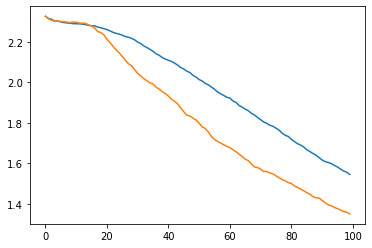

In [148]:
plt.plot(ne_base.fitdata.mean(axis=-1)['loss'])
plt.plot(ne_ae.fitdata.mean(axis=-1)['loss'])

In [204]:
n_gens = 100

nes = []
nes_new = []
for delta in [1e-3, 2e-3, 4e-3, 8e-3]:
    for seed in tqdm(range(10)):
        torch.manual_seed(seed); np.random.seed(seed)
        pheno_class = models_pheno.SmallNet
        pheno = pheno_class().to(device)
        breeder_class = models_breed.UniformBreeder
        breeder = breeder_class().to(device)
        mutator_class = partial(models_mutate.AGMutator, eps=1e-2, adaptive_eps=True, delta=delta)
        mutator = mutator_class().to(device)
        ne = Neuroevolution()
        ne.run_evolution(n_gens, calc_fitdata_fn=partial(task.calc_pop_fitness, n_samples=500, device=device), tqdm=tqdm, leave=False)
        nes.append(ne)


In [215]:
fd = MultiArr.stack([ne.fitdata for ne in nes])
fd=fd.reshape((4, 10, 100, 50))
# fd2 = MultiArr.stack([ne.fitdata for ne in nes_new])

In [225]:
fd.shape

(4, 10, 100, 50)

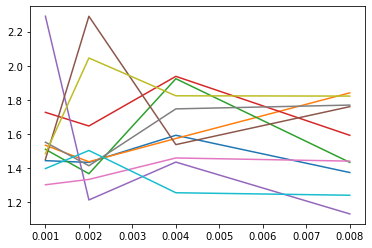

In [222]:
plt.plot([1e-3, 2e-3, 4e-3, 8e-3],fd.mean(axis=(3))[:, :, -1]['loss'])
# plt.plot(fd.mean(axis=3).std(1)[:, -1]['loss'])

(4, 10, 100)


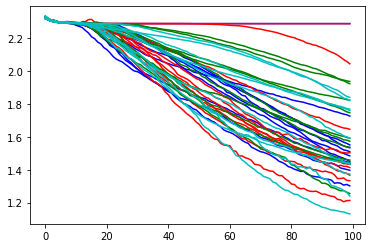

In [208]:
print(fd.shape)
for f, c in zip(fd, ['b', 'r', 'g', 'c']):
    for fi in f:
        plt.plot(fi['loss'], c=c)


In [160]:
print(fd.mean(axis=(0,2))[-1]['loss'])
print(fd2.mean(axis=(0,2))[-1]['loss'])

1.5051796426773072
1.5212110483646393


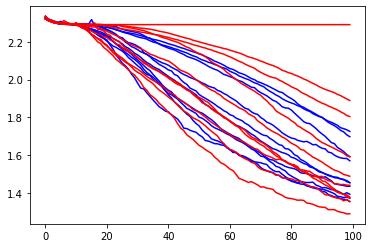

In [164]:
for f in fd.mean(axis=-1):
    plt.plot(f['loss'], c='b')
for f in fd2.mean(axis=-1):
    plt.plot(f['loss'], c='r')

# plt.errorbar(x=np.arange(100), 
#              y=fd.mean(axis=(0, 2))['loss'],
#              yerr=fd.std(axis=(0, 2))['loss'])
# plt.errorbar(x=np.arange(100), 
#              y=fd2.mean(axis=(0, 2))['loss'],
#              yerr=fd2.std(axis=(0, 2))['loss'])

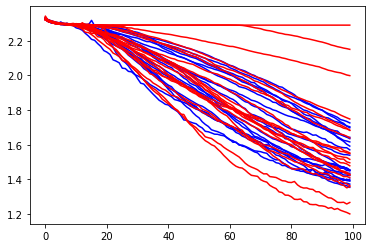

In [131]:
for f in fd.mean(axis=-1):
    plt.plot(f['loss'], c='b')
for f in fd2.mean(axis=-1):
    plt.plot(f['loss'], c='r')

# plt.errorbar(x=np.arange(100), 
#              y=fd.mean(axis=(0, 2))['loss'],
#              yerr=fd.std(axis=(0, 2))['loss'])
# plt.errorbar(x=np.arange(100), 
#              y=fd2.mean(axis=(0, 2))['loss'],
#              yerr=fd2.std(axis=(0, 2))['loss'])

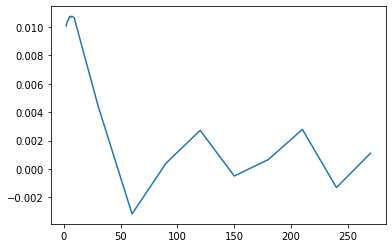

In [84]:
a = np.array(list(ne_ae.pop_evol.values()))
a = np.array(list(map(lambda x: x.mutator_weights.detach().cpu().numpy().mean(), a.flatten())))
a = a.reshape(-1,50)
plt.plot(list(ne_ae.pop_evol.keys()), a.mean(axis=-1))

(11, 50, 130)


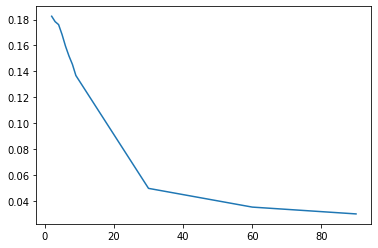

In [62]:
gens = ne.pop_evol.keys()
weights = np.array([[geno.pheno_weights.detach().cpu().numpy() for geno in pop_gen] 
          for gen_idx, pop_gen in ne.pop_evol.items()])
print(weights.shape)
plt.plot(gens, weights.std(axis=1).mean(axis=-1))

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390])


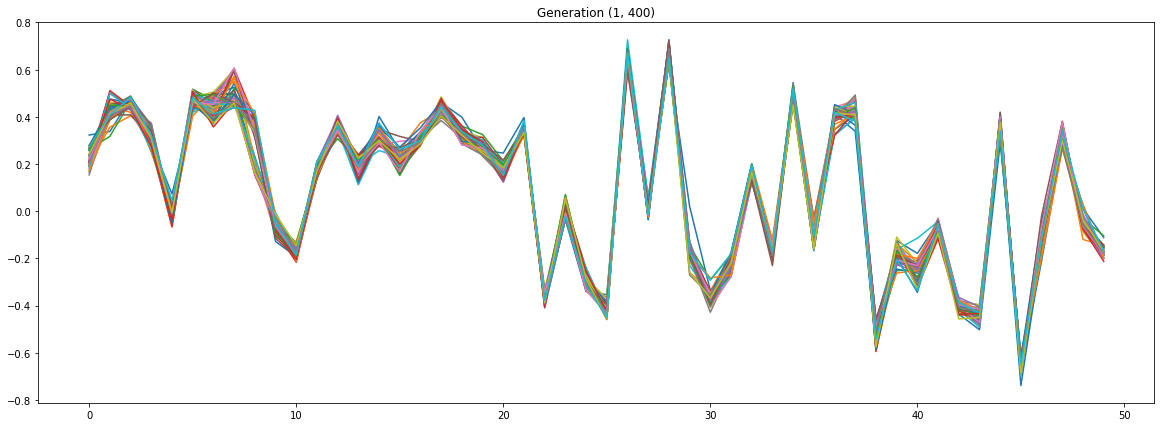

0.02923328


In [45]:
print(ne.pop_evol.keys())
gen_idx = 390
w = np.array([geno.pheno_weights.detach().cpu().numpy() for geno in ne.pop_evol[gen_idx]])
plt.figure(figsize=(20,7))
plt.plot(w[:, :50].T)
plt.title(f'Generation {key}')
plt.show()
print(w.std(axis=0).mean())

(-0.04, 0.04)

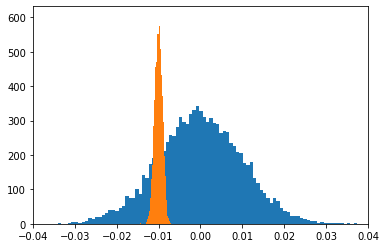

In [67]:
plt.hist(1e-2*np.random.randn(10000), bins=100);
plt.hist(models_mutate.ConvMutator().mutate(torch.randn(10300)).detach().cpu().numpy(), bins=100);
plt.xlim(-4e-2, 4e-2)

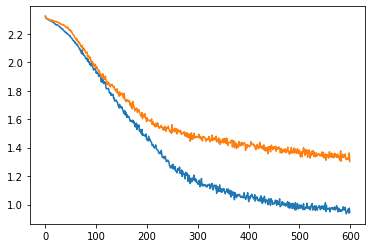

In [113]:
plt.plot(util.arr_dict2dict_arr(util.arr_dict_mean(np.array(ne_base.fitdata_evol), axis=-1))['loss'])
plt.plot(util.arr_dict2dict_arr(util.arr_dict_mean(np.array(ne_ae.fitdata_evol), axis=-1))['loss'])

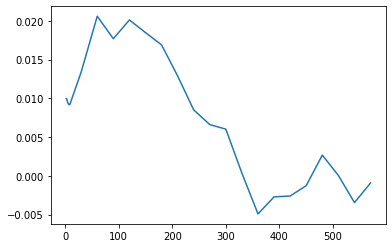

In [122]:
a = np.array(list(ne_ae.pop_evol.values()))
a = np.array(list(map(lambda x: x.mutator_weights.detach().cpu().numpy(), a.flatten()))).reshape(27,100)
plt.plot(list(ne_ae.pop_evol.keys()), a.mean(axis=-1))

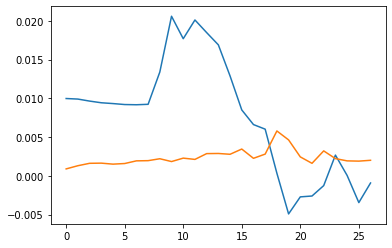

In [110]:
plt.plot(a.mean(axis=-1));
plt.plot(a.std(axis=-1));

In [239]:
weights = np.array([[geno.pheno_weights.detach().cpu().numpy() for geno in pop_gen] for pop_gen in ne.pop_evol.values()])
weights.shape

(17, 100, 130)

In [240]:
X = weights.reshape(-1, weights.shape[-1])
# Xp = TSNE(n_components=2).fit_transform(X)
Xp = PCA(n_components=2).fit_transform(X)
Xp = Xp.reshape(*weights.shape[:2], 2)
Xp.shape

(17, 100, 2)

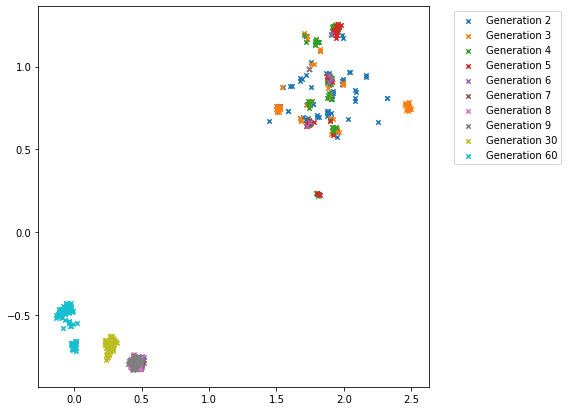

In [241]:
plt.figure(figsize=(7, 7))
for i, Xpi in enumerate(Xp[:10]):
    plt.scatter(*Xpi.T, s=20, marker='x', label=f'Generation {list(ne.pop_evol.keys())[i]}')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [177]:
from sklearn.manifold import TSNE
X = np.random.randn(1000, 3000)
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(1000, 2)

In [238]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [272]:
fitdata_gens = cmaes.run_cmaes(models_pheno.SmallNet, task.calc_pheo_fitness, 300, 30, device, tqdm)

(15_w,30)-aCMA-ES (mu_w=8.6,w_1=20%) in dimension 130 (seed=964664, Wed Jun 16 16:53:26 2021)


In [10]:
torch.load('data/mnist_sgd_eval')

{models_pheno.SmallNet: {'fitness': -0.6912355422973633,
  'loss': 0.6912355422973633,
  'accuracy': 78.32249999999999},
 models_pheno.ConvNet: {'fitness': -0.28138837218284607,
  'loss': 0.28138837218284607,
  'accuracy': 91.6425},
 models_pheno.BigConvNet: {'fitness': -0.10598196089267731,
  'loss': 0.10598196089267731,
  'accuracy': 96.65}}